# Classification with logistic regression, decision trees and Random Forests

Ως τώρα έχουμε γνωρίσει ορισμένους σημαντικούς αλγορίθμους μηχανικής μάθησης.  Ως τώρα έχουμε εφαρμόσει κυρίως τους αλγορίθμους αυτούς  σε προβλήματα regression.  
Όμως, μπορούμε με τους ίδιους αλγορίθμους, αντί να προβλέψουμε την τιμή ενός σπιτιού ή την ποιότητα ενός κρασιού, να προβλέψουμε την κατηγορία που ένα στοιχείο ανήκει.
Ένα συχνό παράδειγμα καητοριοποίησης, προέρχεται από τον ιατρικό κλάδο και συγκεκριμένα ή κατηγοριοποίηση ενός όγκου ως καλοήθη ή κακοήθη. A
 



Χρήσιμοι Σύνδεσμοι (ημερομ. πρόσβασης 2.6.2020):

- https://realpython.com/logistic-regression-python/

- https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer

- https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets

- https://elitedatascience.com/imbalanced-classes

- https://machinelearningmastery.com/cross-validation-for-imbalanced-classification/


In [0]:
# Import packages that we will need in the exercise
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedKFold, train_test_split
from sklearn import datasets

## Importing and preparing the data

We will use a dataset from sklearn.

In [0]:
# Load the data
cancer_set = datasets.load_breast_cancer()
# Transform data to a dataframe
cancer_df = pd.DataFrame(cancer_set.data, columns=cancer_set.feature_names)
# Add the target column 
cancer_df['diagnosis'] = pd.Series(cancer_set.target)

In [3]:
# View the first lines of our dataframe
cancer_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


Now our data is ready. First warm-up exercise:
We have a total sample of 569 samples. 212 of them are malignant and 357 benign. 
Do the ones or the zeros indicate the malignant cases?
You will find the solution below.


In [0]:
# Check which classes correspond to benign or malignant. 



## Cleaning the data

In [5]:
# Check whether we have cases to exclude due to missing data
print("Shape of the dataframe: "+str(cancer_df.shape))
# Check for missing values
print("Missing values: \n"+str(cancer_df.isnull().sum()))

Shape of the dataframe: (569, 31)
Missing values: 
mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
diagnosis                  0
dtype: int64


In [6]:
# Although we did not find a missing value, here we work through the pipeline that we would use to exclude missing values
# a. Making a list of missing value types
missing_values = ["n/a", "na", "--", 999,9999]   
# b. Replace values - the line below means: df.replace(what should be replaced, with which value, do not make a copy of df)
cancer_df.replace(to_replace = missing_values, value = np.nan, inplace = True) 
# c. Drop lines containing NaNs 
cancer_df.dropna(inplace=True) 
# d. Reindex the dataframe. After deletion of the missing values, index do not fit anymore, because lines are missing
cancer_df.reset_index(drop=True, inplace=True)  
# Check the dimensions over again. We did not have to exclude a row due to missing data. 
print("Shape of the dataframe: "+str(cancer_df.shape))

Shape of the dataframe: (569, 31)


In [7]:
# Now let's see which one is malignant and which benign
np.sum(cancer_df.diagnosis)
# Remember we have 212 malignant cases and 357 benign

357

## Balancing the data

One aspect that needs to be taken care of in classification tasks is the number of samples per class. In our data we have about 63% benign cases. When we just always predict "benign" we would perform above chance level with an accuracy of 63%, but our model would be far away from what we want it to do. Namely, to predict the class beloning based on the input data.

One possible solution is majority subsampling. In this approach we create a new dataset by randomly sampling from the larger class until we have a new set of equal size compared to the smaller class. This procedure is called class balancing.


In [0]:
# Get benign cases
df_benign = cancer_df[cancer_df['diagnosis'] == 1]
# Get malignant cases
df_malignant = cancer_df[cancer_df['diagnosis'] == 0]

In [9]:
# For the balacing itself we use the function resample from sklearn.utils
from sklearn.utils import resample
# Resample majority class (benign)
df_benign_downsampled = resample(df_benign, 
                                 replace=False,    # sample without replacement
                                 n_samples=212,    # to match minority class
                                 random_state=123) # reproducible results
# Check whether we now have the same size (should be 212 rows)
print("Shape of the benign class data: "+str(df_benign_downsampled.shape))
# Join the two sets again --> creats a balanced dataset
cancer_df_balanced = pd.concat([df_benign_downsampled, df_malignant])
# View the first and last lines of our dataframe
print(cancer_df_balanced.head())
print(cancer_df_balanced.tail())

Shape of the benign class data: (212, 31)
     mean radius  mean texture  ...  worst fractal dimension  diagnosis
388       11.270         15.50  ...                  0.10430          1
116        8.950         15.76  ...                  0.07722          1
58        13.050         19.31  ...                  0.06289          1
234        9.567         15.91  ...                  0.08178          1
109       11.340         21.26  ...                  0.08832          1

[5 rows x 31 columns]
     mean radius  mean texture  ...  worst fractal dimension  diagnosis
563        20.92         25.09  ...                  0.09873          0
564        21.56         22.39  ...                  0.07115          0
565        20.13         28.25  ...                  0.06637          0
566        16.60         28.08  ...                  0.07820          0
567        20.60         29.33  ...                  0.12400          0

[5 rows x 31 columns]


# Logistic regression 

The application of Logistic Regression looks very similar to the application of Linear Regression. We create a Logistic Regression object, then train it, and eventually use it for our predictions. We will use the Logistic Regression in a 10 times 10 cross validation loop to estimate the performance of the method on this dataset.

Note: We no longer use the R² as a metric, but accuracy, because R² is only applyable in regression but not in classification tasks.

Accuracy is calculated as:

Accuracy = true prediction / all predictions

In [0]:
# Import logistic regression class, accuracy score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
# Prepare datframe for machine-learning (split in x and y)
X = cancer_df_balanced.drop(columns = 'diagnosis')
y = cancer_df_balanced['diagnosis']
# Initiate the model score list
model_score = []
# Initalize list of true labels
true_labels = []
# Initialize list of predicted labels
predicted_labels = []
# Instanciate our Cross-Validation (cv) object
our_cv = RepeatedKFold(n_splits=10, n_repeats=10)
# Instanciate Logistic Regression 
log_reg = LogisticRegression(penalty='none', random_state=123, solver='saga', max_iter = 10000, warm_start=True)
# Loop through the splits produced by cv
for i_train, i_test in our_cv.split(X):
    # Define our current training and test set according to the current split
    X_train, X_test, y_train, y_test = X.iloc[i_train], X.iloc[i_test], y.iloc[i_train], y.iloc[i_test]
    # Fitting the logistic regression
    log_reg.fit(X_train, y_train.astype('int'))
    # Predicting the testing data
    y_pred_test = log_reg.predict(X_test)
    # Getting accuracy score
    model_score.append(accuracy_score(y_test.astype('int'), y_pred_test.astype('int')))
    # Add true labels to list
    true_labels.extend(y_test.astype('int'))
    # Add predicted labels to list
    predicted_labels.extend(y_pred_test.astype('int'))

## Classification performance

There are different metrics used to evaluate our models performance. One common measure is the earlier introduced accuaracy. We calculate the score inside the cross-validation and take the mean in the end. 

In [11]:
# Calculate the average accuracy over the 10-times 10-fold cross validation 
# Using n.mean over the 100 values in model_score
print("Average accuracy of the logistic regression model is: "+str(np.mean(model_score))+" %")

Average accuracy of the logistic regression model is: 0.909269102990033 %


#### Visualizing the model performance

A confusion matrix is a good way to see for which type of examples the model performs well/not so well on. 
It illustrates the predicted classes versus the true classes in a matrix notation.

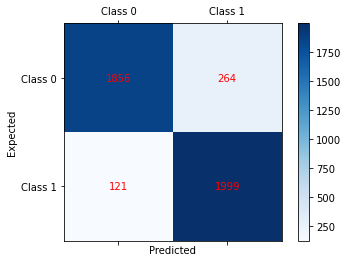

In [12]:
# Create confusion matrix to visualize the correct/incorrect predictions
# Import the confusion matrix function
from sklearn.metrics import confusion_matrix
# Compute the confusion matrix
conf_mat = confusion_matrix(y_true=true_labels, y_pred=predicted_labels)
# Define the labels for the confusion matrix
labels = ['Class 0', 'Class 1']
# Initiate an empty figure
fig = plt.figure()
# Add axis to the figure
ax = fig.add_subplot(111)
# Add the actual matrix
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
# Show a colorbar
fig.colorbar(cax)
# Remove x and y ticks
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
# Add x and y labels
plt.xlabel('Predicted')
plt.ylabel('Expected')
# Add new x and y ticks
for i in range(2):
    for j in range(2):
        ax.text(j, i, conf_mat[i, j], ha='center', va='center', color='r')
# Show the plot
plt.show()

In the matrix above, each row corresponds to a class and shows how often the method classified right (e.g. class0 as class0) or wrong (e.g. class 0 as class 1).

If you want to dive even deeper into the different classification metrics have a look at the scikitlearn documentation:

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#:~:text=sklearn.,precision_recall_fscore_support&text=The%20precision%20is%20intuitively%20the,the%20number%20of%20false%20negatives.

## Decision trees

Now that we have seen the performance of our logistic regression we can explore tree based methods for classification and see whether they can perform even better. 

In [0]:
# Import decision tree class
from sklearn import tree
# Initiate the model score list
model_score = []
# Initalize list of true labels
true_labels = []
# Initialize list of predicted labels
predicted_labels = []
# Instanciate our Cross-Validation (cv) object
our_cv = RepeatedKFold(n_splits=10, n_repeats=10)
# Instanciate decision tree classifier (this is a fully grown, hence not optimized decison tree)
dec_tree = tree.DecisionTreeClassifier()
# Loop through the splits produced by cv
for i_train, i_test in our_cv.split(X):
    # Define our training and test set according to current split
    X_train, X_test, y_train, y_test = X.iloc[i_train], X.iloc[i_test], y.iloc[i_train], y.iloc[i_test]
    # Fitting the tree
    dec_tree.fit(X_train, y_train.astype('int'))
    # Predicting the testing data
    y_pred_test = dec_tree.predict(X_test)
    # Getting accuracy score
    model_score.append(accuracy_score(y_test.astype('int'), y_pred_test.astype('int')))
    # Add true labels to list
    true_labels.extend(y_test.astype('int'))
    # Add predicted labels to list
    predicted_labels.extend(y_pred_test.astype('int'))

In [14]:
# Calculate the average accuracy over the 10-times 10-fold cross validation 
# Using n.mean over the 100 values in model_score
print("Average accuracy of the decision tree model is: "+str(np.mean(model_score))+" %")

Average accuracy of the decision tree model is: 0.9290697674418606 %


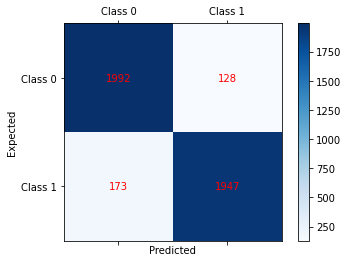

In [15]:
# Create confusion matrix to visualize the correct/incorrect predictions
# Import the confusion matrix function
from sklearn.metrics import confusion_matrix
# Compute the confusion matrix
conf_mat = confusion_matrix(y_true=true_labels, y_pred=predicted_labels)
# Define the labels for the confusion matrix
labels = ['Class 0', 'Class 1']
# Initiate an empty figure
fig = plt.figure()
# Add axis to the figure
ax = fig.add_subplot(111)
# Add the actual matrix
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
# Show a colorbar
fig.colorbar(cax)
# Remove x and y ticks
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
# Add x and y labels
plt.xlabel('Predicted')
plt.ylabel('Expected')
# Add new x and y ticks
for i in range(2):
    for j in range(2):
        ax.text(j, i, conf_mat[i, j], ha='center', va='center', color='r')
# Show the plot
plt.show()

## Random Forest classifier

In [0]:
# Import Random forest classifier
from sklearn.ensemble import RandomForestClassifier
# Initiate the model score list
model_score = []
# Initalize list of true labels
true_labels = []
# Initialize list of predicted labels
predicted_labels = []
# Instanciate our Cross-Validation (cv) object
our_cv = RepeatedKFold(n_splits=10, n_repeats=10)
# Instanciate decision tree classifier 
dec_tree =RandomForestClassifier(n_estimators=100)
# Loop through the splits produced by cv
for i_train, i_test in our_cv.split(X):
    # Define our training and test set according to current split
    X_train, X_test, y_train, y_test = X.iloc[i_train], X.iloc[i_test], y.iloc[i_train], y.iloc[i_test]
    # Fitting the tree
    dec_tree.fit(X_train, y_train.astype('int'))
    # Predicting the testing data
    y_pred_test = dec_tree.predict(X_test)
    # Getting accuracy score
    model_score.append(accuracy_score(y_test.astype('int'), y_pred_test.astype('int')))
    # Add true labels to list
    true_labels.extend(y_test.astype('int'))
    # Add predicted labels to list
    predicted_labels.extend(y_pred_test.astype('int'))

In [17]:
# Calculate the average accuracy over the 10-times 10-fold cross validation 
# Using n.mean over the 100 values in model_score
print("Average accuracy of the random forests model is: "+str(np.mean(model_score))+" %")

Average accuracy of the random forests model is: 0.9653709856035438 %


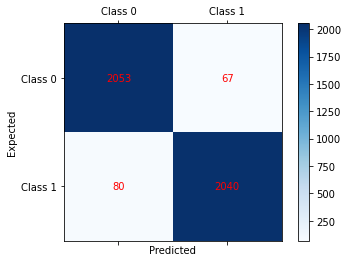

In [18]:
# Create confusion matrix to visualize the correct/incorrect predictions
# Import the confusion matrix function
from sklearn.metrics import confusion_matrix
# Compute the confusion matrix
conf_mat = confusion_matrix(y_true=true_labels, y_pred=predicted_labels)
# Define the labels for the confusion matrix
labels = ['Class 0', 'Class 1']
# Initiate an empty figure
fig = plt.figure()
# Add axis to the figure
ax = fig.add_subplot(111)
# Add the actual matrix
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
# Show a colorbar
fig.colorbar(cax)
# Remove x and y ticks
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
# Add x and y labels
plt.xlabel('Predicted')
plt.ylabel('Expected')
# Add new x and y ticks
for i in range(2):
    for j in range(2):
        ax.text(j, i, conf_mat[i, j], ha='center', va='center', color='r')
# Show the plot
plt.show()

It seems that decsion tree based methods can predict this dataset better than the logistic regression. And within the decision tree based methods, random forests seems to be the superior method. Here we can speculate that since the decision tree methods are able to capture non-lienar relationships and since they perform better, that this dataset has indeed non-linear relathionships between predictors and classes.

# Συγχαρητήρια που ολοκληρώσατε ένα ακόμα μάθημα ML!



#### Άσκηση  

Θα επαναλάβουμε αυτά που μάθαμε παραπάνω σε ένα διαφορετικό παράδειγμα.
Τη Μηχανική Μάθηση μπορούμε να την εφαρμόσουμε σε πολλους τομείς και τώρα θα μεταβούμε από την πρόβλεψη καρκινικών όγκων στην εύρεση πλαστογραφημμένων χαρτονομισμάτων!
 
Το  Banknote Dataset περιέχει δεδομένα σχετικά με χαρακτηριστικά από χαρτονομίσματα και συγκεκριμένα δολάρια και παρουσιάζει ποια από αυτά είναι πλαστά και ποια όχι.


Είναι ένα δυαδικό (2-class) πρόβλημα κατηγοριοποίησης. Ο αριθμός των παρατηρίσεων δεν είναι σε ισορροπία (un-balanced data). Υπάρχουν 1,372 παρατηρήσεις σε 4 μεταβλητές εισόδου και μία μεταβλητή εξόδου.
Τα ονόματα των μεταβλητών είναι τα εξής:

- Variance of Wavelet Transformed image (continuous).
- Skewness of Wavelet Transformed image (continuous).
- Kurtosis of Wavelet Transformed image (continuous).
- Entropy of image (continuous).
- Class (0 για αυθεντικά, 1 για πλαστά).

Στόχος:
Χρησιμοποιήστε τις παραπάνω τεχνικές κατηγοριοποίησης και προσπαθήστε να προβλέψετε ποια χαρτονομίσματα είναι αυθεντικά και ποια πλαστά.  Τα δεδομένα θα τα βρείτε στο github που δείχνουμε παρακάτω. 
(Hint: Θυμηθείτε το data balancing)


Πηγή:

http://archive.ics.uci.edu/ml/datasets/banknote+authentication

που έχει αντιγραφεί στο github:

https://raw.githubusercontent.com/cmourlas/ML-algorithms/master/week10/data_banknote_authentication.csv

Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.